In [1]:
import numpy as np
import pandas as pd
import os
import Pre_process as Pp
import distance
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# from leven import levenshtein       
from tqdm import tqdm
from random import sample
from sklearn.cluster import AffinityPropagation
from sklearn.feature_extraction.text import CountVectorizer
from kmodes.kmodes import KModes
from sklearn.metrics import adjusted_rand_score

In [2]:
# Loading data
data_path = '../data/RC_1/'

def load_data(data_path):
    parcours = os.path.join(data_path, 'Log_parcours_complets.csv')
    violation = os.path.join(data_path, 'Violations.csv')
    trace = os.path.join(data_path, 'Fichier des traces.xlsx')
    Parcours = pd.read_csv(parcours, sep=";")
    Violations = pd.read_csv(violation, sep=";", dtype='str')
    #Trace = pd.read_excel(trace, dtype='str')
    EventID, Event= Parcours.EventID, Parcours.Event
    return Parcours, Violations, EventID, Event

Parcours, Violations, EventID, Event = load_data(data_path)
Parcours.head()

,EventID,Event,EventTS
0,1,14,2020-03-17 05:00:00
1,1,10,2020-03-17 10:44:05
2,1,11,2020-03-17 11:23:08
3,1,4,2020-03-18 10:26:26
4,1,13,2020-03-20 14:00:00


In [3]:
# EventID, Event, ID_list= Parcours.EventID, Parcours.Event, set(EventID)

In [4]:
ID_list = set(EventID)
def data_prep(EventID, n_sample, ID_list, Parcours):
    ID_list= set(EventID)
    #n_sample = 500
    ID_list_sampling = sample(ID_list,n_sample)
    list_event = []
    k=0
    for i in tqdm(range(len(ID_list_sampling))): 
        tmp = Parcours.loc[Parcours['EventID']==ID_list_sampling[i]].Event
        values = ' '.join([str(l) for l in tmp])
        list_event.append(values)
    print('done...')
    return list_event, ID_list_sampling, ID_list

list_event, ID_list_sampling, ID_list = data_prep(EventID, 500, ID_list, Parcours)

# Data formating
def formatage(list_event, ID_list_sampling):
    data_sampling = {'Id_event': ID_list_sampling, 'Event': list_event}
    data_sampling = pd.DataFrame(data_sampling)
    return data_sampling
data_sampling = formatage(list_event, ID_list_sampling)
data_sampling.head()

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 55.24it/s]


done...


,Id_event,Event
0,846274,14 10 11 12 9 17 15 13 16
1,776364,14 10 11 13 12 9 3 2 17 17 15 15 16
2,206955,14 10 11 12 9 1 17 15 15 13 16
3,864083,14 10 9 1 13 17 15 16
4,897234,14 10 11 12 9 13 17 17 15 15 16


In [5]:
def levenshtein(texts):
    '''
    Levenshtein Distance
    - It requires negative similarities, so -1 * levenshtein(t1, t2)
    '''
    texts = np.asarray(texts, dtype=object)
    _similarity = np.array([[distance.levenshtein(list(w1),list(w2)) for w1 in texts] for w2 in texts])
    _similarity = -1*_similarity
    return _similarity

def text_clustering(texts, similarity=levenshtein, word_level=False):
    '''Text Clustering'''
    # similarity
    if word_level: texts = [t.split() for t in texts]
    _similarity = levenshtein(texts)
    _affprop = AffinityPropagation(affinity="precomputed", damping=0.5, verbose=True,
        random_state=0, max_iter=1_000, convergence_iter=10)
    _affprop.fit(_similarity)
    return _affprop, _similarity


def print_clusters(affprop, texts):
    '''Print clusters'''
    texts = np.asarray(texts)
    clusters = np.unique(affprop.labels_)
    print(f'\n~ Number of texts:: {texts.shape[0]}')
    print(f'~ Number of clusters:: {clusters.shape[0]}')
    if clusters.shape[0] < 2: return 'Only few clusters - Stopped'
    for cluster_id in clusters:
        exemplar = texts[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(texts[np.nonzero(affprop.labels_==cluster_id)])
        cluster_str = '";\n  "'.join(cluster)
        print(f'\n# Cluster ({cluster_id}) with ({len(cluster)}) elements')
        print(f'Exemplar:: {exemplar}')
        print(f'\nOthers::\n  "{cluster_str}"')

In [6]:
# # Clustering a sample af events
# texts = data_sampling.Event
# affprop, _ = text_clustering(texts, similarity=levenshtein, word_level=True)
# print_clusters(affprop, texts)

In [7]:
# # Load trace cluster
# trace = os.path.join(data_path, 'Fichier des traces.xlsx')
# Trace = pd.read_excel(trace, dtype='str')
# Trace.head()

# # Replace "-" by ","
# traces = Trace.Traces
# List_traces = []
# for i in tqdm(range(len(traces))):
#     List_traces.append(traces[i].replace('-', ','))

#### Cluster using one-hot-encoding

In [8]:
# Creat columns
df = data_sampling
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.Event)

df = pd.DataFrame(X.toarray())
col_names = ['c_'+str(l) for l in vectorizer.get_feature_names()]
df.columns = col_names
df.head()

,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18
0,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,2,1,2,0
2,1,1,1,1,1,2,1,1,0
3,1,0,0,1,1,1,1,1,0
4,1,1,1,1,1,2,1,2,0


In [9]:
# Distance matrix X using levenshtein
X= levenshtein(data_sampling.Event)

# Kmode object using X
clusters = KModes(n_clusters=2).fit_predict(X)
# clusters = km.

# Formatage
data_sampling.index = data_sampling.Id_event
Violation_sample = Violations.filter(items=ID_list_sampling, axis = 0)
Violation_sample['Cluster'] = clusters

# Select violation
Violation_sample = Violation_sample.drop(['EventID'], axis=1)
nom_var = Violation_sample.columns

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 62.71it/s]


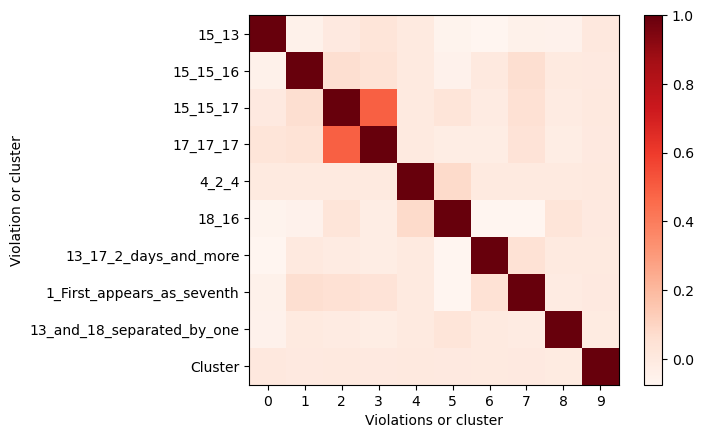

In [10]:
# Calculate ARI matrix
def distance_matrxi(nom_var, Violation_sample):
    ARI_tab = np.zeros((len(nom_var),len(nom_var)))
    for i in tqdm(range(len(nom_var))):
        for j in range(len(nom_var)):
            ARI_tab[i,j] = adjusted_rand_score(Violation_sample[nom_var[i]], Violation_sample[nom_var[j]])
    return ARI_tab

ARI_tab = distance_matrxi(nom_var, Violation_sample)
        
# Plot the heatmap of ARI'S matrix
fig, ax = plt.subplots()
heatmap = ax.imshow(ARI_tab, cmap='Reds')

# Add labels and colorbar
ax.set_xticks(np.arange(ARI_tab.shape[1]))
ax.set_yticks(np.arange(ARI_tab.shape[0]))
#ax.set_xticklabels(nom_var)
ax.set_yticklabels(nom_var)
ax.set_xlabel('Violations or cluster')
ax.set_ylabel('Violation or cluster')
fig.colorbar(heatmap)

plt.show()

### Make the same analysis with the real data

In [11]:
# Loading data
data_path = '../data/RC_2/'
Parcours, Violations, EventID, Event = load_data(data_path)
Parcours.head()

,EventID,Event,EventTS
0,1,4,29/09/2022 13:32
1,1,7,30/09/2022 17:41
2,1,3,30/09/2022 18:22
3,1,6,01/10/2022 00:25
4,1,2,01/10/2022 01:44


In [12]:
# Data prep and formatage
list_event, ID_list_sampling, ID_list = data_prep(EventID, 500, ID_list, Parcours)
data_sampling = formatage(list_event, ID_list_sampling)
data_sampling.head()

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 795.48it/s]

done...


,Id_event,Event
0,16550,4 7 3 6 2 8 1
1,49177,4 7 3 6 2 8 1
2,35889,4 7 3 6 2 8 1
3,68414,4 7 3 6 2 8 1
4,118307,4 7 3 6 2 8 1


In [13]:
# Distance matrix X using levenshtein
X= levenshtein(data_sampling.Event)

# Kmode object using X
clusters = KModes(n_clusters=2).fit_predict(X)
# clusters = km.

# Formatage
data_sampling.index = data_sampling.Id_event
Violation_sample = Violations.filter(items=ID_list_sampling, axis = 0)
Violation_sample['Cluster'] = clusters

# Select violation
Violation_sample = Violation_sample.drop(['ID'], axis=1)
nom_var = Violation_sample.columns

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.82it/s]


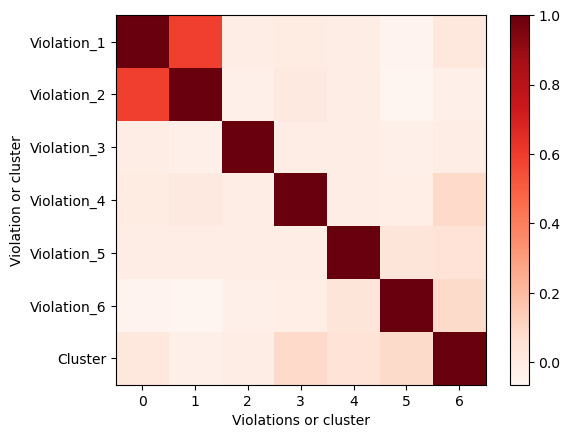

In [14]:
# Calculate ARI matrix
ARI_tab = distance_matrxi(nom_var, Violation_sample)
        
# Plot the heatmap of ARI'S matrix
fig, ax = plt.subplots()
heatmap = ax.imshow(ARI_tab, cmap='Reds')

# Add labels and colorbar
ax.set_xticks(np.arange(ARI_tab.shape[1]))
ax.set_yticks(np.arange(ARI_tab.shape[0]))
#ax.set_xticklabels(nom_var)
ax.set_yticklabels(nom_var)
ax.set_xlabel('Violations or cluster')
ax.set_ylabel('Violation or cluster')
fig.colorbar(heatmap)

plt.show()